# Spanish Electricity Pool Forecasting: Import Finacial Data from Quandl

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import quandl as qua

In [2]:
import config

TOKEN = config.QUANDL_API_KEY
PATH = "./data/"

sns.set(
    rc=config.set_plot_features(), style="darkgrid"
       )

In [3]:
START_DATE="2014-01-01"
END_DATE = dt.datetime.now().date().strftime("%Y-%m-%d")

start_date_suffix = START_DATE.replace("-","_")
end_date_suffix = END_DATE.replace("-","_")

In [4]:
END_DATE

'2019-06-11'

### Download finantial data from Quandl API:

https://www.quandl.com/tools/api

**Download CO2 Emissions Allowances prices**

https://www.quandl.com/data/CHRIS/ICE_C1-ECX-EUA-Futures-Continuous-Contract

In [5]:
TICKER = "CHRIS/ICE_C1"
co2_raw = qua.get(TICKER, start_date=START_DATE, end_date=END_DATE, authtoken=TOKEN)
co2_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1420 entries, 2014-01-02 to 2019-06-10
Data columns (total 11 columns):
Open                       1230 non-null float64
High                       1230 non-null float64
Low                        1230 non-null float64
Settle                     1420 non-null float64
Change                     1404 non-null float64
Wave                       977 non-null float64
Volume                     1076 non-null float64
Prev. Day Open Interest    1419 non-null float64
EFP Volume                 365 non-null float64
EFS Volume                 60 non-null float64
Block Volume               516 non-null float64
dtypes: float64(11)
memory usage: 133.1 KB


**Download Coal API2 prices**

The API 2 price assessment is the benchmark price reference for coal imported to northwest Europe. It is calculated as an average of the Argus cif ARA price assessment and the IHS McCloskey NW Europe Steam Coal marker.


https://www.quandl.com/data/CHRIS/CME_MTF2-Coal-API2-CIF-ARA-ARGUS-McCloskey-Futures-Continuous-Contract-2-MTF2

In [6]:
TICKER = "CHRIS/CME_MTF2.6"
coal_raw = qua.get(TICKER, start_date=START_DATE, end_date=END_DATE, authtoken=TOKEN)
coal_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1328 entries, 2014-02-18 to 2019-06-10
Data columns (total 1 columns):
Settle    1328 non-null float64
dtypes: float64(1)
memory usage: 20.8 KB


**Download Natural Gas at TTF prices**

The Title Transfer Facility, more commonly known as TTF, is a virtual trading point for natural gas in the Netherlands

https://www.quandl.com/data/CHRIS/ICE_TFM1-Endex-Dutch-TTF-Gas-Base-Load-Futures-Continuous-Contract

In [7]:
TICKER = "CHRIS/ICE_TFM1.4"
ng_raw = qua.get(TICKER, start_date=START_DATE, end_date=END_DATE, authtoken=TOKEN)
ng_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1398 entries, 2014-01-02 to 2019-06-10
Data columns (total 1 columns):
Settle    1398 non-null float64
dtypes: float64(1)
memory usage: 21.8 KB


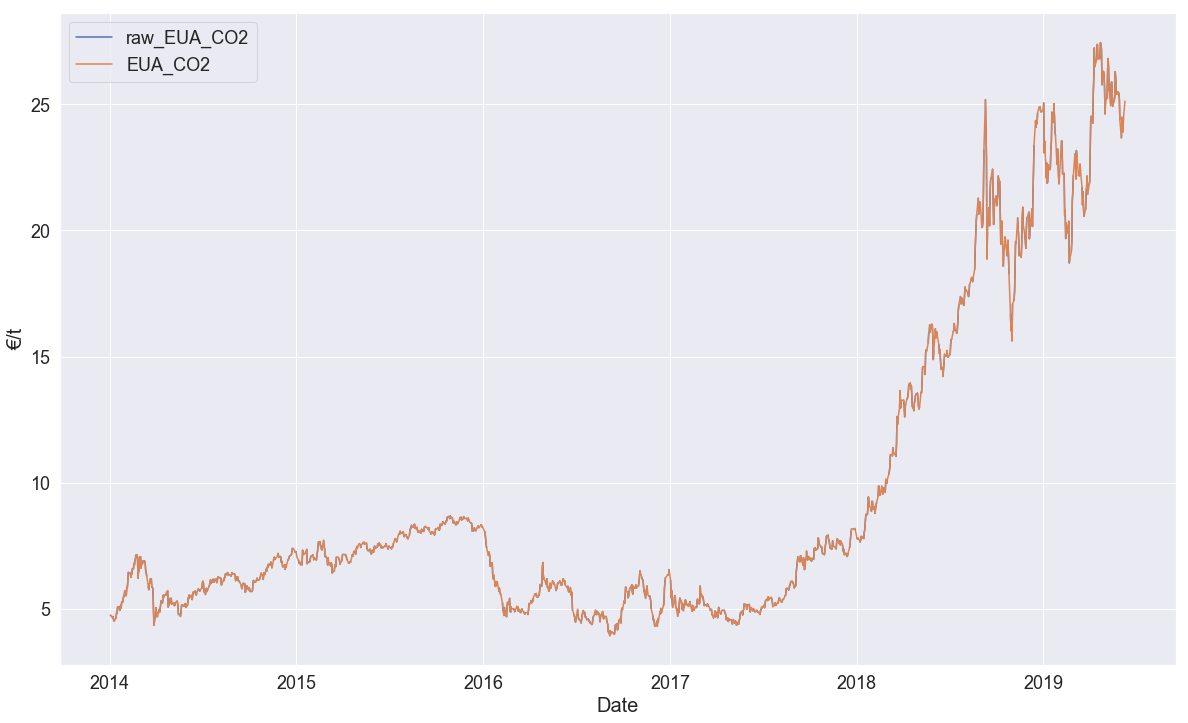

In [8]:
co2_df = co2_raw["Settle"].to_frame("raw_EUA_CO2").asfreq(freq ="D")
co2_df["MI_EUA_CO2"] = co2_df["raw_EUA_CO2"].isna().astype(int)
co2_df["EUA_CO2"] = co2_df["raw_EUA_CO2"].interpolate(method = "linear")
co2_df[["raw_EUA_CO2", "EUA_CO2"]].plot()
plt.ylabel("€/t")
plt.show()

In [9]:
def resample_df(input_df: pd.DataFrame, output_df: pd.DataFrame, 
                freq: str, interpolation: str,
                raw_col: str, mi_col: str, fill_col:str):
    output_df = input_df.copy()
    output_df = output_df.asfreq(freq = freq)
    output_df[mi_col] = output_df[raw_col].isna().astype(int)
    output_df[fill_col] = output_df[raw_col].interpolate(method = interpolation)
    return output_df

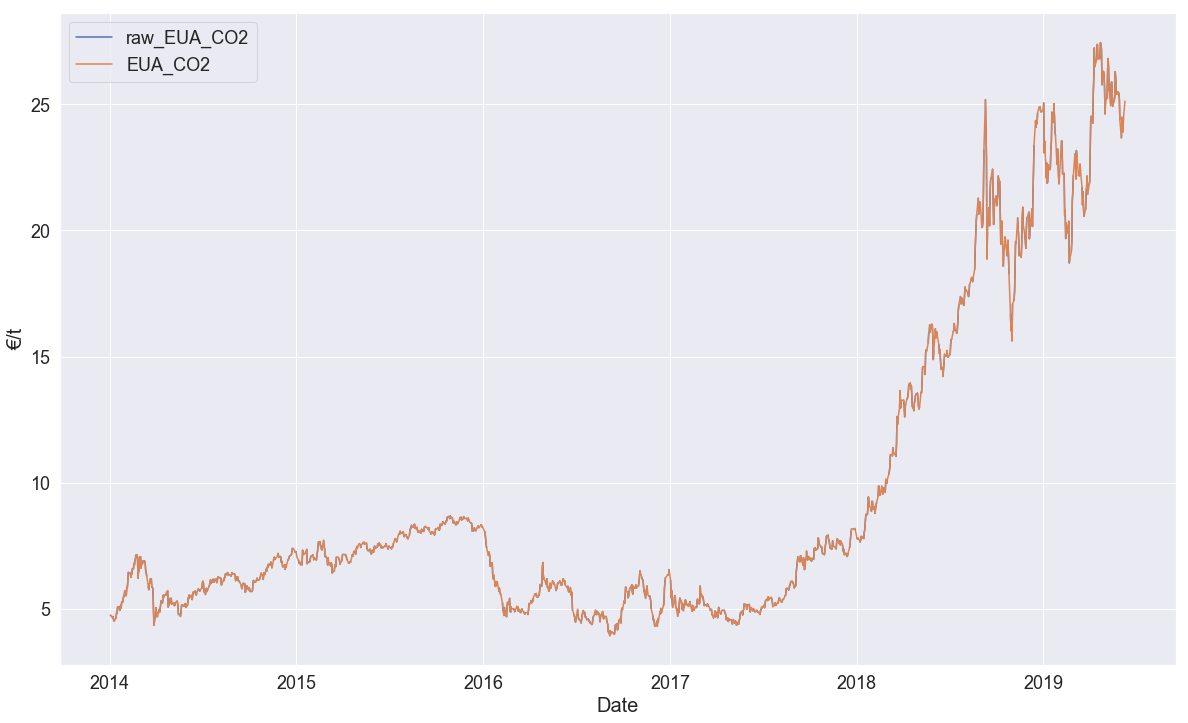

In [10]:
co2_df = co2_raw["Settle"].to_frame("raw_EUA_CO2")
co2_df = resample_df(input_df=co2_df, output_df=co2_df, 
                freq="D", interpolation="linear",
                raw_col="raw_EUA_CO2", mi_col="MI_EUA_CO2", fill_col="EUA_CO2")
co2_df[["raw_EUA_CO2", "EUA_CO2"]].plot()
plt.ylabel("€/t")
plt.show()

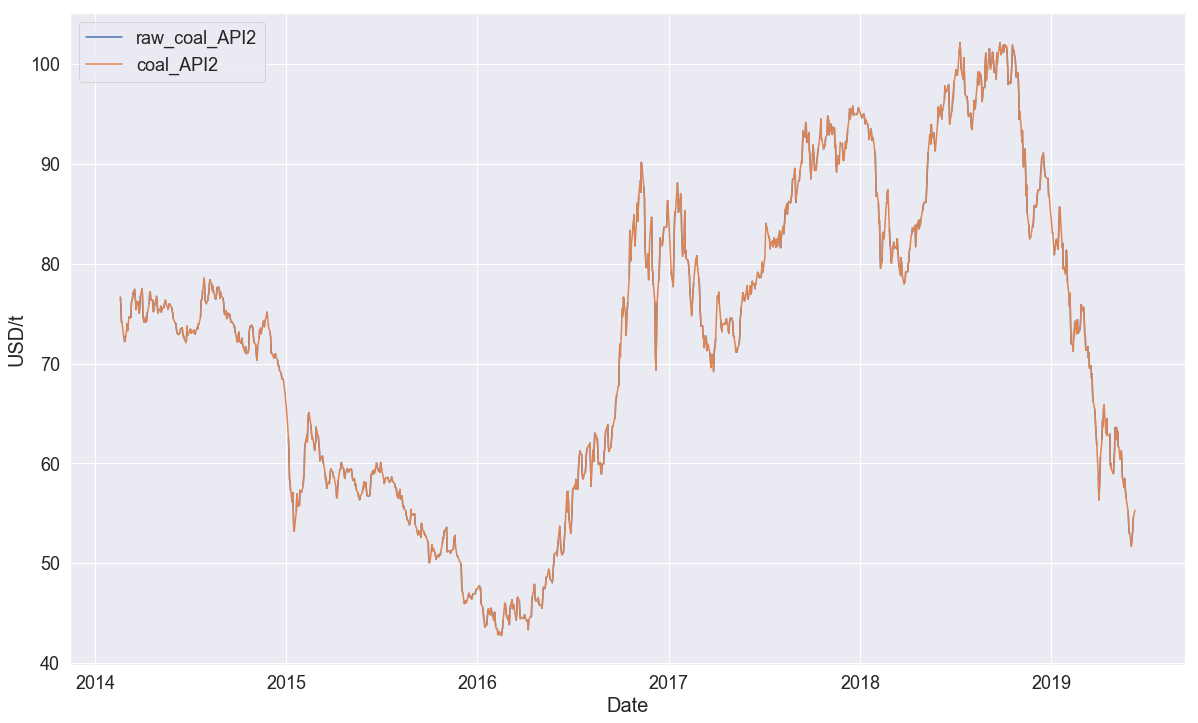

In [11]:
coal_df = coal_raw["Settle"].to_frame("raw_coal_API2")
coal_df = resample_df(input_df=coal_df, output_df=coal_df, 
                freq="D", interpolation="linear",
                raw_col="raw_coal_API2", mi_col="MI_coal_API2", fill_col="coal_API2")
coal_df[["raw_coal_API2", "coal_API2"]].plot()
plt.ylabel("USD/t")
plt.show()

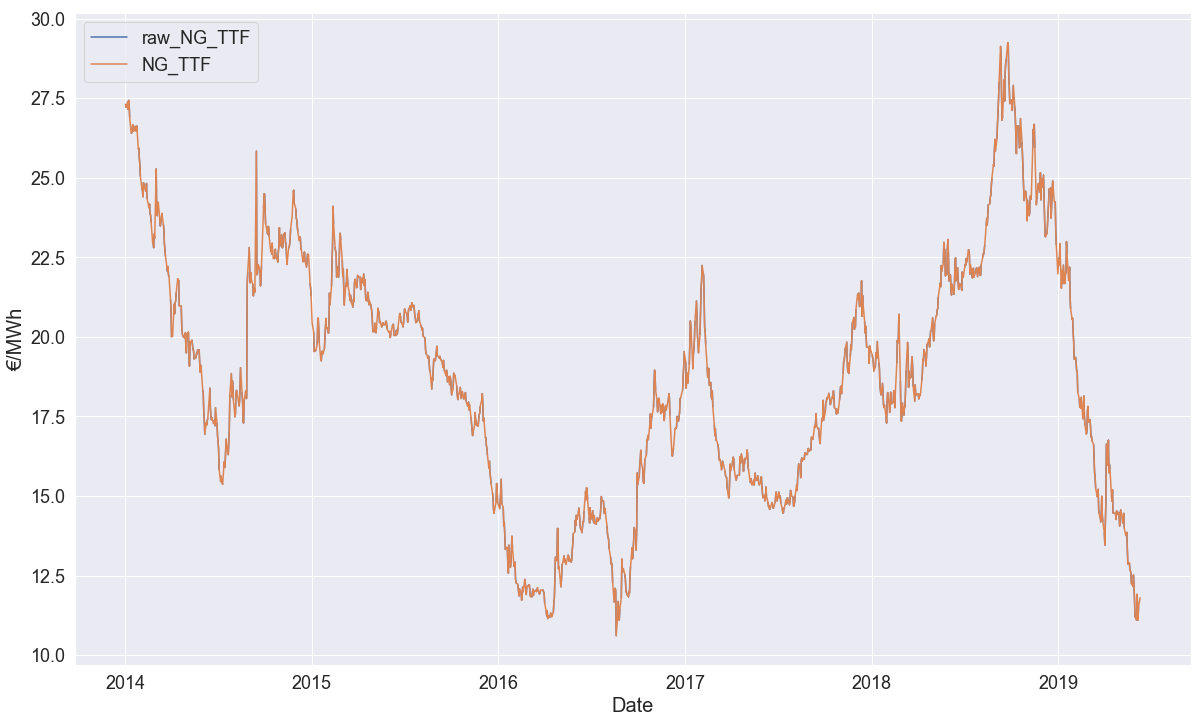

In [12]:
ng_df = ng_raw["Settle"].to_frame("raw_NG_TTF")
ng_df = resample_df(input_df=ng_df, output_df=ng_df, 
                freq="D", interpolation="linear",
                raw_col="raw_NG_TTF", mi_col="MI_NG_TTF", fill_col="NG_TTF")
ng_df[["raw_NG_TTF", "NG_TTF"]].plot()
plt.ylabel("€/MWh")
plt.show()

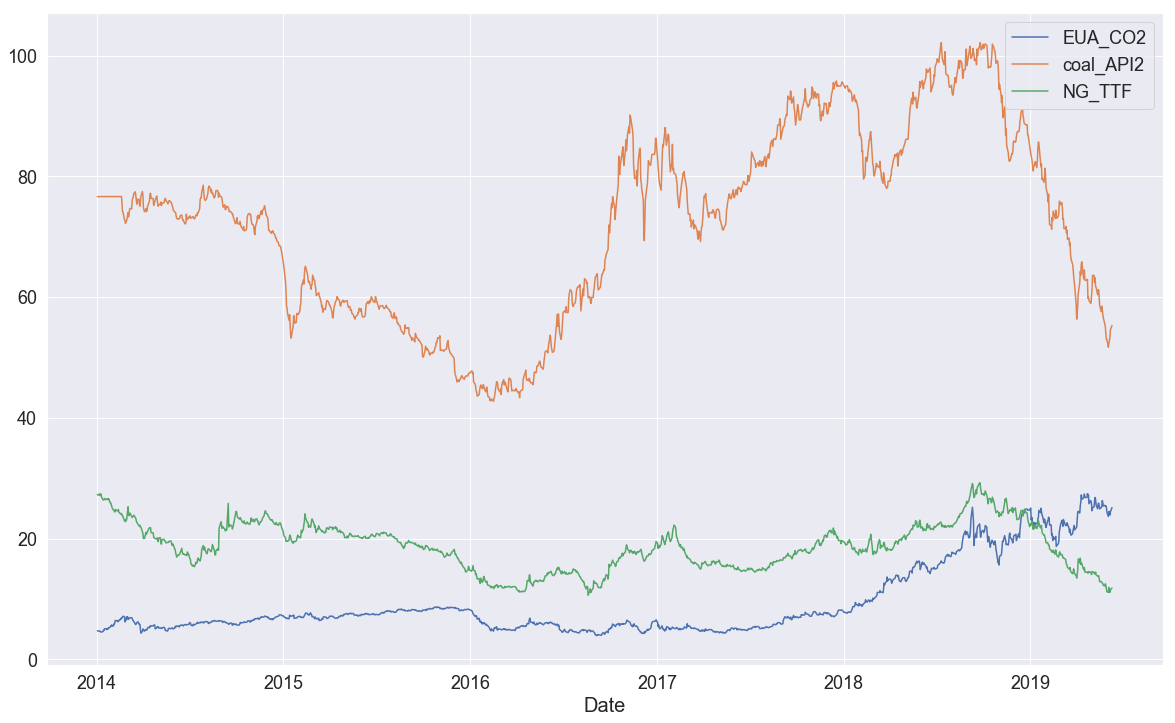

In [13]:
fin_data = pd.concat([co2_df, coal_df,ng_df], axis=1)[['EUA_CO2', 'coal_API2','NG_TTF']].fillna(method ='bfill')
fin_data.plot()
plt.show()

In [14]:
fin_data.head(5)

,EUA_CO2,coal_API2,NG_TTF
Date,,,
2014-01-02,4.740000,76.65,27.302
2014-01-03,4.720000,76.65,27.213
2014-01-04,4.693333,76.65,27.266
2014-01-05,4.666667,76.65,27.319
2014-01-06,4.640000,76.65,27.372


In [15]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1986 entries, 2014-01-02 to 2019-06-10
Freq: D
Data columns (total 3 columns):
EUA_CO2      1986 non-null float64
coal_API2    1986 non-null float64
NG_TTF       1986 non-null float64
dtypes: float64(3)
memory usage: 142.1 KB


In [16]:
fin_data.to_csv(PATH + "quand_daily.csv", index_label="date")